# MLF HW2

## Import libs

In [1]:
import warnings

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from Ref.ch03 import plot_decision_regions

## Loading data & preprocessing

In [2]:
data = pd.read_csv("Data/cs-training.csv", index_col=0)

y_feature = "SeriousDlqin2yrs"
X_features = list(data.columns)
X_features.remove(y_feature)

data[X_features] = data[X_features].fillna(data[X_features].mean())
data_train = data.dropna(subset=y_feature)

X = data[X_features]
y = data[y_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sd = sc.fit_transform(X_train)
X_test_sd = sc.transform(X_test)

## Extract  features using PCA method
### Plot explained variance


Eigenvalues 
[2.99468873 1.52885561 1.22574242 0.5443703  0.73331573 0.93751269
 1.00117799 1.01033026 0.01729004 0.00679957]


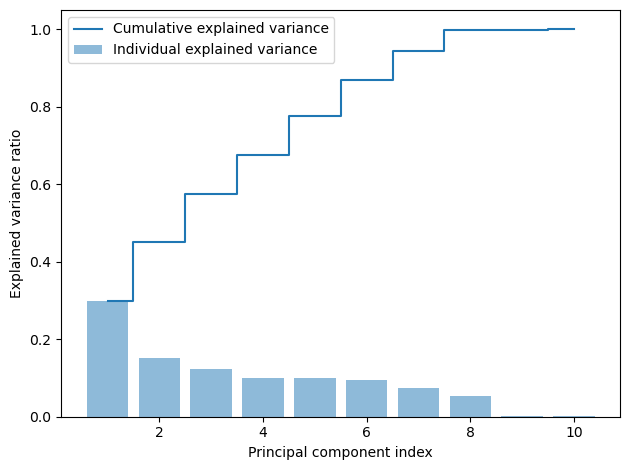

In [3]:
cov_mat = np.cov(X_train_sd.transpose())
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, len(var_exp)+1), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, len(var_exp)+1), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Since top 6 features explain about 86% of variance, 6 components will be kept in further process.

## Implementing RF with pipeline & 5-fold CV

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pipe_RF = make_pipeline(StandardScaler(),
                        PCA(n_components=6),
                        RandomForestClassifier(random_state=1))

param_grid = [{'randomforestclassifier__max_depth': [1, 2, 3, 4, 5], 
               'randomforestclassifier__criterion': ['gini', 'entropy'],
               'randomforestclassifier__n_estimators': [10, 20, 50, 100]}]

gs = GridSearchCV(estimator=pipe_RF, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1, verbose=2)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

clf = gs.best_estimator_

print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
0.9341833333333334
{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 10}
Test accuracy: 0.935
